## Mapping FREE Agribalyse_database (ready-to-eat food products) wh user selected LCIA

AGRIBALYSE® data is freely available:
https://doc.agribalyse.fr/documentation-en/agribalyse-data/data-access

in this notebook, we extract mapping for the "ready-to-eat food products" 

we use ' simplified version, accessible to everyone : '
- two spreadsheets for raw conventional agricultural products and organic products (at the farm gate)
- a spreadsheet for feed (available soon),
- a spreadsheet for ready-to-eat food products.


LCIA implemented as shown in spreadsheet: 
- Score unique EF 3.1 
- EF Method 3.0 - implémentation SimaPro (adapted) V1.00 / EF3.0 normalization and weighting set
- ref on the LCIA EF3.0: 
    - https://link.springer.com/article/10.1007/s11367-019-01604-y/tables/1
    - https://link.springer.com/article/10.1007/s11367-019-01604-y/tables/3

In [1]:
# dataframe tools
import pandas as pd
import numpy as np
from tqdm import tqdm

# metrics functions
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

# custom package
from caml import config
from caml.similarity import MLModel

# interactive input tools
import ipywidgets as widgets
from ipywidgets import VBox
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../Module')  #a level up & then down to Module folder
from lci_ml_mod import *

In [3]:
#url = 'https://data.ademe.fr/data-fair/api/v1/datasets/agribalyse-31-synthese/metadata-attachments/AGRIBALYSE3.1_produits%20alimentaires_2.xlsm'
agri_df = pd.read_excel("data/AGRIBALYSE3.1_produits alimentaires_2.xlsm", sheet_name =  "Detail etape", header = [1,2])
#agri_df.head()

In [4]:
#agri_df.columns  # LCIA score: except first 8 cols and last four cols,also excl col 9-14 -mPt / kg de produit
all_lcia = agri_df.columns[15:-5]

In [5]:
IC_name = ["Climate_change", "Ozone_depletion", "Ionizing_radiation", "Photochemical_ozone_formation",
          "Particulate_matter", "Human_toxicity_non-cancer", "Human_toxicity_cancer", "Acidification",
          "Eutrophication_freshwater", "Eutrophication_marine", "Eutrophication_terrestrial", 
          "Ecotoxicity_freshwater", "Land_use", "Water_use", "Resource_use_fossils", "Resource_use_minerals-and-metals"]

In [6]:
lcia_unit = [all_lcia[i][0] for i in list(range(0, len(all_lcia), 7))]  #each IC has 7 life cycle stage
#lcia_unit

In [7]:
# store unit for each impact category, will be used for table headers / plotting label
dict_IC_unit = {IC_name[i]: lcia_unit[i] for i in range(len(lcia_unit))}
dict_IC_unit

{'Climate_change': 'kg CO2 eq/kg de produit',
 'Ozone_depletion': 'kg CVC11 eq/kg de produit',
 'Ionizing_radiation': 'kBq U-235 eq/kg de produit',
 'Photochemical_ozone_formation': 'kg NMVOC eq/kg de produit',
 'Particulate_matter': 'disease inc./kg de produit',
 'Human_toxicity_non-cancer': 'CTUh/kg de produit',
 'Human_toxicity_cancer': 'CTUh/kg de produit',
 'Acidification': 'mol H+ eq/kg de produit',
 'Eutrophication_freshwater': 'kg P eq/kg de produit',
 'Eutrophication_marine': 'kg N eq/kg de produit',
 'Eutrophication_terrestrial': 'mol N eq/kg de produit',
 'Ecotoxicity_freshwater': 'CTUe/kg de produit',
 'Land_use': 'Pt/kg de produit',
 'Water_use': 'm3 depriv./kg de produit',
 'Resource_use_fossils': 'MJ/kg de produit',
 'Resource_use_minerals-and-metals': 'kg Sb eq/kg de produit'}

### Extract all LCI that will be mapped against your input product

In [8]:
agri_list = agri_df[("Unnamed: 5_level_0","LCI Name")].values  #two headers here, using all lines
#print(len(agri_list))

### User input impact category - directly define in the list, add in as many IC as you like

In [9]:
sel_ic_multiple = ["Water_use", "Climate_change"] #, "Eutrophication_freshwater"

#### Extract all LCIA scores according to user selected impact category, this output will be used in follow-up datatable/plotting

In [10]:
LC_lcia = agribs_extract_lcia (dict_IC_unit, lcia_unit, sel_ic_multiple, agri_df)

### start ML mapping user input product to the database

In [11]:
product_list = [
    "pourover coffee, arabica, Yirgacheffe",
    "icecream, chocolate",
    "pizza, pepperoni",
    "softdrink, coca cola",
]

In [12]:
model = MLModel(config.model_name)
cosine_scores = model.compute_similarity_scores(product_list, agri_list)

### Only see LCI mapped with highest cosine_score, w/h total LCIA score (not breakding down into LC stage)

In [13]:
ss = map_agribs_single_lci_wh_lcia(cosine_scores, dict_IC_unit, sel_ic_multiple, product_list, agri_list , LC_lcia)
ss[0]

,your product,AGRIBALYSE_mapped,m3 depriv./kg de produit,cosine_score
0,"pourover coffee, arabica, Yirgacheffe","Coffee, powder, instant, non rehydrated",16.504718,0.544
1,"icecream, chocolate","Ice cream, chocolate coated",1.017572,0.798
2,"pizza, pepperoni","Pizza, cheese and tomato or Margherita pizza",2.086665,0.747
3,"softdrink, coca cola","Cola, with sugar and artificial sweetener(s)",1.566365,0.618


In [14]:
ss[1]

,your product,AGRIBALYSE_mapped,kg CO2 eq/kg de produit,cosine_score
0,"pourover coffee, arabica, Yirgacheffe","Coffee, powder, instant, non rehydrated",27.066247,0.544
1,"icecream, chocolate","Ice cream, chocolate coated",1.749729,0.798
2,"pizza, pepperoni","Pizza, cheese and tomato or Margherita pizza",1.639887,0.747
3,"softdrink, coca cola","Cola, with sugar and artificial sweetener(s)",0.512049,0.618


### If you wanna see first N [up to 20, define in below first input, 8 in the example] closest mapped product,  w/h all life cycle stage LCIA impact scores

In [15]:
final_result = map_agribs_multiple_lci_wh_lcia(8, cosine_scores,dict_IC_unit, sel_ic_multiple, product_list, agri_list, LC_lcia)

In [16]:
final_result[0]

AGRIBALYSE_mapped  \
your_product                                                                                                                                                           
pourover coffee, arabica, Yirgacheffe Water_use 1                                                                            Coffee, powder, instant, non rehydrated   
                                                2                                                    Coffee with milk or Cappuccino, powder, instant, non rehydrated   
                                                3                                                              Decaffeinated coffee, powder, instant, non rehydrated   
                                                4                                                         Mix of chicory and coffee, powder, instant, non rehydrated   
                                                5                                     Coffee with milk or Cappuccino with chocolate, powder, instant, non rehydrated   
                                                6                                                                              Custard dessert, coffee, refrigerated   
                                                7  Mix of chicory and coffee, instant, without sugar, ready-to-drink (reconstituted with standard semi-skimmed milk)   
                                                8                       Mix of chicory and coffee, instant, without sugar, ready-to-drink (reconstituted with water)   
icecream, chocolate                   Water_use 1                                                                                        Ice cream, chocolate coated   
                                                2                                                                     Dark chocolate, filled with mint confectionery   
                                                3                                                                                                     Chocolate cake   
                                                4                                                                                             Milk chocolate, filled   
                                                5                                                                                              Candies, marshmallows   
                                                6                                                                                              Ice cream, cone, mini   
                                                7                                                                                 Custard dessert, chocolate, canned   
                                                8                                                                                                 Milk chocolate bar   
pizza, pepperoni                      Water_use 1                                                                       Pizza, cheese and tomato or Margherita pizza   
                                                2                                                                                        Pizza, cheese and mushrooms   
                                                3                                                                                                     Pizza, chicken   
                                                4                                                                                           Pizza, chorizo or salami   
                                                5                                                                                                        Pizza, tuna   
                                                6                                                                                                     Pizza, seafood   
                                                7                                                                  

In [18]:
final_result[1]

AGRIBALYSE_mapped  \
your_product                                                                                                                                                                
pourover coffee, arabica, Yirgacheffe Climate_change 1                                                                            Coffee, powder, instant, non rehydrated   
                                                     2                                                    Coffee with milk or Cappuccino, powder, instant, non rehydrated   
                                                     3                                                              Decaffeinated coffee, powder, instant, non rehydrated   
                                                     4                                                         Mix of chicory and coffee, powder, instant, non rehydrated   
                                                     5                                     Coffee with milk or Cappuccino with chocolate, powder, instant, non rehydrated   
                                                     6                                                                              Custard dessert, coffee, refrigerated   
                                                     7  Mix of chicory and coffee, instant, without sugar, ready-to-drink (reconstituted with standard semi-skimmed milk)   
                                                     8                       Mix of chicory and coffee, instant, without sugar, ready-to-drink (reconstituted with water)   
icecream, chocolate                   Climate_change 1                                                                                        Ice cream, chocolate coated   
                                                     2                                                                     Dark chocolate, filled with mint confectionery   
                                                     3                                                                                                     Chocolate cake   
                                                     4                                                                                             Milk chocolate, filled   
                                                     5                                                                                              Candies, marshmallows   
                                                     6                                                                                              Ice cream, cone, mini   
                                                     7                                                                                 Custard dessert, chocolate, canned   
                                                     8                                                                                                 Milk chocolate bar   
pizza, pepperoni                      Climate_change 1                                                                       Pizza, cheese and tomato or Margherita pizza   
                                                     2                                                                                        Pizza, cheese and mushrooms   
                                                     3                                                                                                     Pizza, chicken   
                                                     4                                                                                           Pizza, chorizo or salami   
                                                     5                                                                                                        Pizza, tuna   
                                                     6                                                                                                     Pizza, seafood   


#### Let's plot out the all LCIA scores for the multiple IC of different life cycle stage for a selected product 

In [19]:
#name = input( ("Select which product to plot and copy in the text box: \n " + str(product_list) ))

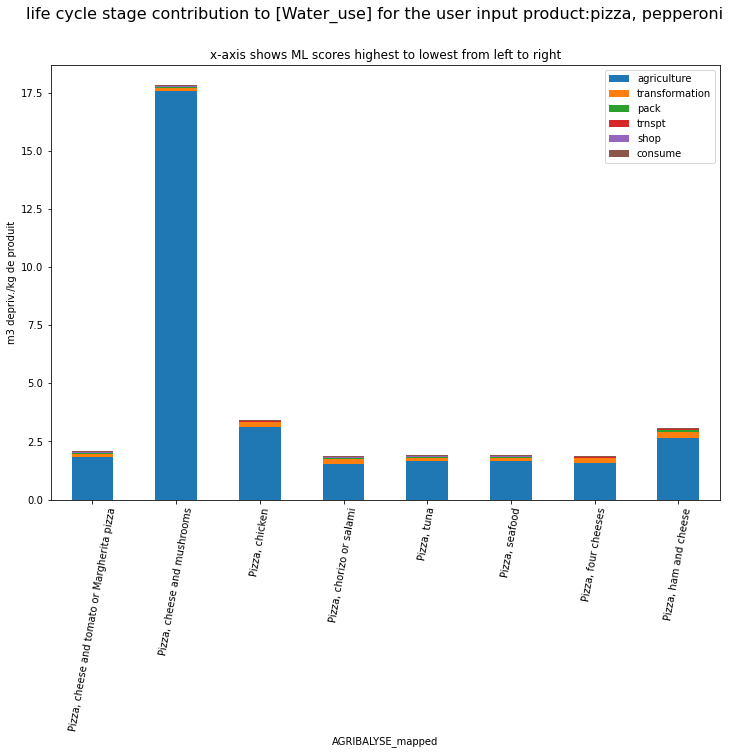

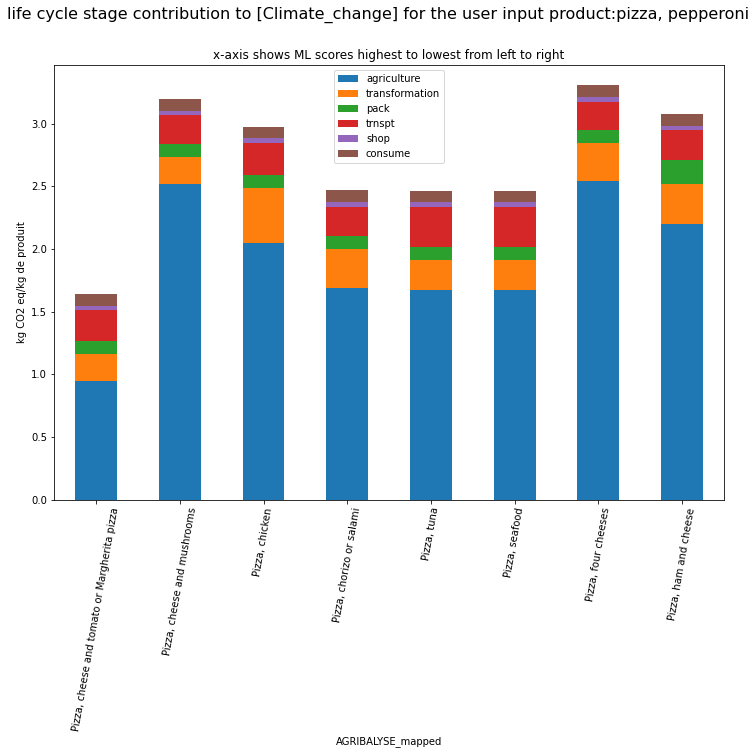

In [20]:
# or directly define product name here:
name = 'pizza, pepperoni'

for i, sel_ic in zip( range(len(sel_ic_multiple)), sel_ic_multiple):
    plot_df = final_result[i].loc[name,:]
    plot_df.plot.bar(x="AGRIBALYSE_mapped", stacked = True, y=["agriculture", "transformation","pack", "trnspt", "shop","consume"], 
                     ylabel = dict_IC_unit.get(sel_ic), figsize=(12,8) )
    plt.xticks(rotation = 80)
    plt.suptitle(("life cycle stage contribution to" + " ["+ sel_ic + "] " + "for the user input product:" + name ), fontsize=16)
    plt.title("x-axis shows ML scores highest to lowest from left to right", fontsize=12)
    plt.show()